# Inteligentná analýza údajov
# Zadanie 2 - predspracovanie údajov

### Michal Greguš, Samuel Kováč

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mat
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
import math
from statsmodels.graphics.gofplots import qqplot
import copy
from sklearn.datasets import load_iris
from scipy.stats import normaltest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler 

data_profiles = pd.read_csv("data/profiles_fixed.csv", sep = '\t')
data_labor = pd.read_csv("data/labor_fixed.csv", sep = '\t')

import warnings
warnings.filterwarnings('ignore')

Inicializovanie potrebných importov, načítanie datasetov do premenných.

### Spojenie datasetov

In [2]:
data = pd.merge(data_profiles,data_labor,on=['name','ssn'], how = 'outer')
data0 = copy.deepcopy(data)

Datasety sme spojili pomocou "OUTER" join-u na základe atribútov **name** a **ssn**. Výsledok môžme vidieť pomocou data.head()

In [3]:
data.head()

,job,company,sex,residence,blood_group,ssn,name,birthdate,race,age,...,indicator,hematokrit,trombocyty,smoker,alt,etytr,erytrocyty,hemoglobin,alp,relationship
0,Chief Marketing Officer,"Torres, Parker and Fisher",F,"584 Chan Unions\r\nNew Robertside, MN 27858",B+,318-35-2572,Lori Delgado,1988-04-12,White,33,...,1.0,9.88330,8.47868,yes,10.25955,8.08841,7.40501,6.77725,77.25589,divorced
1,Chief Marketing Officer,"Torres, Parker and Fisher",F,"584 Chan Unions\r\nNew Robertside, MN 27858",B+,318-35-2572,Lori Delgado,1988-04-12,White,33,...,0.0,6.66963,7.88205,yes,7.74958,5.42715,7.29108,4.55265,44.91433,divorced
2,Chief Marketing Officer,"Torres, Parker and Fisher",F,"584 Chan Unions\r\nNew Robertside, MN 27858",B+,318-35-2572,Lori Delgado,1988-04-12,White,33,...,1.0,4.73731,6.20294,no,4.11068,5.48093,5.88646,6.19318,83.11181,widowed
3,Chief Marketing Officer,"Torres, Parker and Fisher",F,"584 Chan Unions\r\nNew Robertside, MN 27858",B+,318-35-2572,Lori Delgado,1988-04-12,White,33,...,1.0,5.46837,6.68672,yes,11.18838,6.01911,7.63798,6.48949,89.86920,divorced
4,Physiological scientist,Lopez PLC,F,"116 Ryan Extensions\r\nJonesport, ND 67361",B-,528-41-8966,Laura Jones PhD,1919-12-22,White,101,...,0.0,5.14382,7.73217,no,4.10851,5.22777,5.95530,6.22521,87.44522,married


In [4]:
print('Počet záznamov : ',data.shape[0] , '\nPočet atribútov: ', data.shape[1])

Počet záznamov :  9908 
Počet atribútov:  27


In [5]:
data.columns

Index(['job', 'company', 'sex', 'residence', 'blood_group', 'ssn', 'name',
       'birthdate', 'race', 'age', 'leukocyty', 'weight', 'hbver', 'HK group',
       'weight group', 'er-cv', 'ast', 'indicator', 'hematokrit', 'trombocyty',
       'smoker', 'alt', 'etytr', 'erytrocyty', 'hemoglobin', 'alp',
       'relationship'],
      dtype='object')

## 1. Integrácia a čistenie dát 

## Odstraňovanie vychýlených hodnôt

In [6]:
def identify_outliers(data):
    lower = data.quantile(0.25) - 1.5 * stats.iqr(data)
    upper = data.quantile(0.75) + 1.5 * stats.iqr(data)
    
    return data[(data > upper) | (data < lower)]

Na identifikovanie outlierov použijeme funkciu z prvého zadania - *identify_outliers*

Text(0.5, 1.0, 'Distribúcia váhy pred odstránením outlierov')

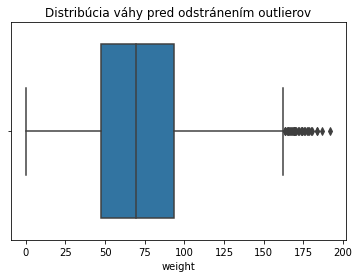

In [7]:
sns.boxplot(data.weight).set_title('Distribúcia váhy pred odstránením outlierov')

Vychýlené hodnoty identifikujeme a následne odstránime z datasetu

In [8]:
weight_out = identify_outliers(data.weight)
data.weight = data.weight.drop(weight_out.index)

Text(0.5, 1.0, 'Distribúcia váhy po odstránení outlierov')

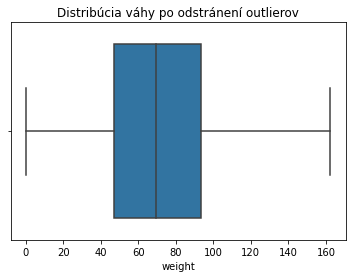

In [9]:
sns.boxplot(data.weight).set_title('Distribúcia váhy po odstránení outlierov')

Funkciu upravíme tak aby vychýlené hodnoty rovno odstraňovala, a použijeme na všetky potrebné atribúty. Na identifikovanie outlierov použijeme stratégiu **IQR** (Inter Quartile Range)

In [10]:
def remove_outliers(data, columns):
    for c in columns:         
        Q1 = data[c].quantile(0.25)
        Q3 = data[c].quantile(0.75)
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        data[c] = data[c].drop(data[c][(data[c] > upper) | (data[c] < lower)].index)
    return data

In [11]:
data.describe()

,age,leukocyty,weight,hbver,er-cv,ast,indicator,hematokrit,trombocyty,alt,etytr,erytrocyty,hemoglobin,alp
count,9908.000000,9878.000000,9873.000000,9878.000000,9878.000000,9878.000000,9908.000000,9878.000000,9878.000000,9878.000000,9878.000000,9878.000000,9878.000000,9878.000000
mean,57.995357,6.793018,70.273760,6.793715,48.350437,49.307390,0.645337,6.369656,6.426925,8.945878,6.032210,6.797049,6.784296,68.515482
std,33.233715,1.525011,33.119698,1.001156,14.136543,12.752349,0.478435,1.591608,1.722116,5.862432,1.502904,1.006155,1.007876,20.352373
min,0.000000,0.997910,0.062440,2.363630,0.000000,0.000000,0.000000,1.172700,0.000000,0.000000,1.027910,2.891940,2.478430,0.000000
25%,29.000000,5.613833,46.997840,6.115040,38.912355,40.636725,0.000000,5.175528,5.191125,5.727078,5.047092,6.128460,6.100168,58.226145
50%,58.000000,6.993640,69.319460,6.785165,48.300335,49.249260,1.000000,6.315170,6.337080,7.528915,5.864550,6.805760,6.777290,75.625600
75%,87.000000,8.016868,93.352730,7.467605,57.923047,57.963300,1.000000,7.587845,7.636613,10.220637,6.848598,7.481435,7.450075,83.710870
max,116.000000,10.690800,162.347770,10.413790,100.000000,100.000000,1.000000,11.187870,13.224870,100.000000,12.900650,10.368620,10.419550,100.000000


In [12]:
remove_columns = ['age', 'leukocyty', 'hbver', 'er-cv', 'ast', 'hematokrit', 'trombocyty', 'erytrocyty', 'hemoglobin']
data = remove_outliers(data, remove_columns)

In [13]:
data.describe()

,age,leukocyty,weight,hbver,er-cv,ast,indicator,hematokrit,trombocyty,alt,etytr,erytrocyty,hemoglobin,alp
count,9908.000000,9876.000000,9873.000000,9807.000000,9811.000000,9810.000000,9908.000000,9875.000000,9858.000000,9878.000000,9878.000000,9798.000000,9803.000000,9878.000000
mean,57.995357,6.794092,70.273760,6.792054,48.375178,49.324339,0.645337,6.371188,6.424773,8.945878,6.032210,6.803877,6.781263,68.515482
std,33.233715,1.523282,33.119698,0.970549,13.753611,12.386757,0.478435,1.589418,1.706778,5.862432,1.502904,0.972814,0.976355,20.352373
min,0.000000,2.106530,0.062440,4.091680,10.444020,14.749830,0.000000,1.635650,1.586720,0.000000,1.027910,4.104700,4.079350,0.000000
25%,29.000000,5.614560,46.997840,6.118100,38.996120,40.718798,0.000000,5.175640,5.192982,5.727078,5.047092,6.136658,6.105255,58.226145
50%,58.000000,6.993985,69.319460,6.783980,48.308330,49.254165,1.000000,6.315610,6.336440,7.528915,5.864550,6.808785,6.775820,75.625600
75%,87.000000,8.017055,93.352730,7.460410,57.859465,57.886197,1.000000,7.588015,7.631527,10.220637,6.848598,7.479385,7.441745,83.710870
max,116.000000,10.690800,162.347770,9.466650,86.434280,83.920060,1.000000,11.187870,11.278320,100.000000,12.900650,9.493170,9.473200,100.000000


## Nahradenie vychýlených hodnôt
Druhou stratégiou odstraňovania vychýlených hodnôt je nahradenie hraničnými hodnotami rozdelenia (5% resp. 95%) Využijeme na to funkcie *clip()* a *quantile()*

In [14]:
def replace_outliers(data):
    return data.clip(lower=data.quantile(0.05), upper=data.quantile(0.95))

In [15]:
alt_before = copy.deepcopy(data.alt)
data.alt = replace_outliers(data.alt)
etytr_before = copy.deepcopy(data.etytr)
data.etytr = replace_outliers(data.etytr)
alp_before = copy.deepcopy(data.alp)
data.alp = replace_outliers(data.alp)

In [16]:
data.describe()

,age,leukocyty,weight,hbver,er-cv,ast,indicator,hematokrit,trombocyty,alt,etytr,erytrocyty,hemoglobin,alp
count,9908.000000,9876.000000,9873.000000,9807.000000,9811.000000,9810.000000,9908.000000,9875.000000,9858.000000,9878.000000,9878.000000,9798.000000,9803.000000,9878.000000
mean,57.995357,6.794092,70.273760,6.792054,48.375178,49.324339,0.645337,6.371188,6.424773,8.551068,6.018805,6.803877,6.781263,68.860965
std,33.233715,1.523282,33.119698,0.970549,13.753611,12.386757,0.478435,1.589418,1.706778,3.945598,1.350251,0.972814,0.976355,19.079332
min,0.000000,2.106530,0.062440,4.091680,10.444020,14.749830,0.000000,1.635650,1.586720,3.712878,3.823988,4.104700,4.079350,24.037958
25%,29.000000,5.614560,46.997840,6.118100,38.996120,40.718798,0.000000,5.175640,5.192982,5.727078,5.047092,6.136658,6.105255,58.226145
50%,58.000000,6.993985,69.319460,6.783980,48.308330,49.254165,1.000000,6.315610,6.336440,7.528915,5.864550,6.808785,6.775820,75.625600
75%,87.000000,8.017055,93.352730,7.460410,57.859465,57.886197,1.000000,7.588015,7.631527,10.220637,6.848598,7.479385,7.441745,83.710870
max,116.000000,10.690800,162.347770,9.466650,86.434280,83.920060,1.000000,11.187870,11.278320,18.926994,8.874401,9.493170,9.473200,89.688798


Môžme vidieť zmeny v počtoch niektorých atribútov datasetu, pričom mediány zostali veľmi podobné.

Text(0.5, 1.0, 'Atribút alp pred nahradením outlierov')

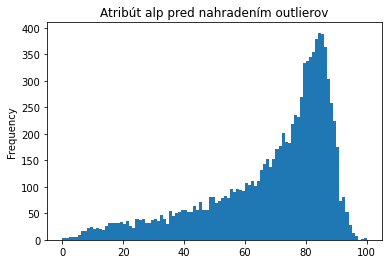

In [17]:
alp_before.plot(kind='hist', bins=100).set_title('Atribút alp pred nahradením outlierov')

Text(0.5, 1.0, 'Atribút alp po nahradení outlierov')

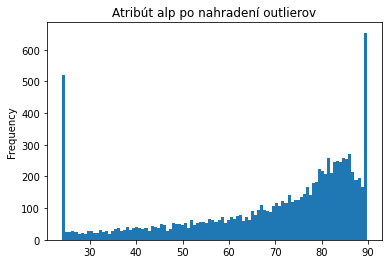

In [18]:
data.alp.plot(kind='hist', bins=100).set_title('Atribút alp po nahradení outlierov')

Vidíme že vychýlené hodnoty boli nahradené hraničnými hodnotami. Podobne je to aj v prípade atribútov **alt** a **etytr**

Text(0.5, 1.0, 'Atribút etytr pred nahradením outlierov')

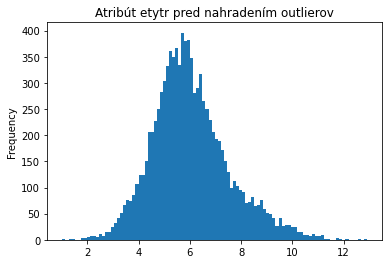

In [19]:
etytr_before.plot(kind='hist', bins=100).set_title('Atribút etytr pred nahradením outlierov')

Text(0.5, 1.0, 'Atribút etytr po nahradení outlierov')

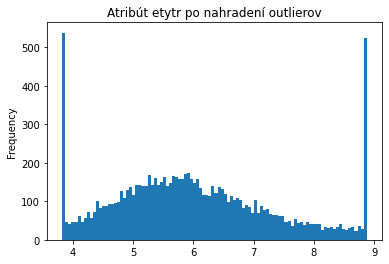

In [20]:
data.etytr.plot(kind='hist', bins=100).set_title('Atribút etytr po nahradení outlierov')

Text(0.5, 1.0, 'Atribút alt pred nahradením outlierov')

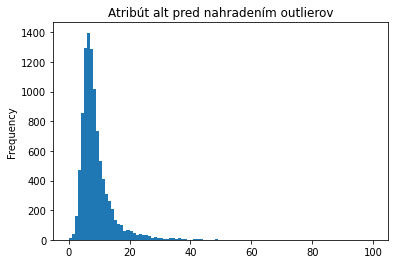

In [21]:
alt_before.plot(kind='hist', bins=100).set_title('Atribút alt pred nahradením outlierov')

Text(0.5, 1.0, 'Atribút alt po nahradení outlierov')

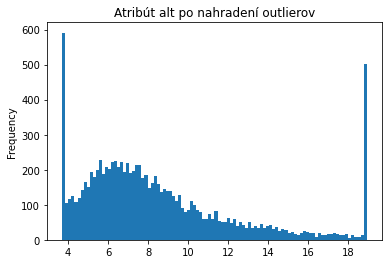

In [22]:
data.alt.plot(kind='hist', bins=100).set_title('Atribút alt po nahradení outlierov')

## Chýbajúce hodnoty

Po odstránení vychýlených hodnôt nám zostalo veľa prázdnych záznamov. V nasledujúcom zozname môžme vidieť všetky chýbajúce hodnoty v záznamoch. Najprv využijeme stratégiu **KNN**.

In [23]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

leukocyty        32
weight           35
hbver           101
HK group         30
weight group    229
er-cv            97
ast              98
hematokrit       33
trombocyty       50
alt              30
etytr            30
erytrocyty      110
hemoglobin      105
alp              30
dtype: int64

Najprv sa musíme zbaviť všetkých nepotrebných atribútov typu string :

In [24]:
numeric_data = data.drop(['job', 'company', 'residence', 'name', 'ssn', 'birthdate', 'HK group', 'weight group', 'sex', 'blood_group', 'race', 'smoker', 'relationship'], axis=1)
numeric_data.columns

Index(['age', 'leukocyty', 'weight', 'hbver', 'er-cv', 'ast', 'indicator',
       'hematokrit', 'trombocyty', 'alt', 'etytr', 'erytrocyty', 'hemoglobin',
       'alp'],
      dtype='object')

Potom pomocou KNNImputer-a doplníme chýbajúce hodnoty v záznamoch.

In [25]:
def knn_imputer(data):
    imputer = KNNImputer(n_neighbors=5)
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [26]:
numeric_data = knn_imputer(numeric_data)

In [27]:
numeric_data[numeric_data.columns[numeric_data.isnull().any()].tolist()].isnull().sum()

Series([], dtype: float64)

Vidíme že všetky chýbajúce hodnoty boli odstránené.
Následne môžme nahradiť vybrané stĺpce našimi novými, vyplnenými stĺpcami.

In [28]:
data['leukocyty'] = numeric_data['leukocyty'].values
data['hbver'] = numeric_data['hbver'].values
data['er-cv'] = numeric_data['er-cv'].values
data['ast'] = numeric_data['ast'].values
data['hematokrit'] = numeric_data['hematokrit'].values
data['trombocyty'] = numeric_data['trombocyty'].values
data['alt'] = numeric_data['alt'].values
data['etytr'] = numeric_data['etytr'].values
data['erytrocyty'] = numeric_data['erytrocyty'].values
data['hemoglobin'] = numeric_data['hemoglobin'].values
data['alp'] = numeric_data['alp'].values

In [29]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

weight           35
HK group         30
weight group    229
dtype: int64

### Nahradenie chýbajúcich hodnôt mediánom
Druhá využitá stratégia nahrádzanie chýbajúcich hodnôt je nahradenie mediánom :

In [30]:
def replace_median(dataset):
    return dataset.fillna(dataset.median())

Text(0.5, 1.0, 'Distribúcia váhy pacientov zobrazená histogramom')

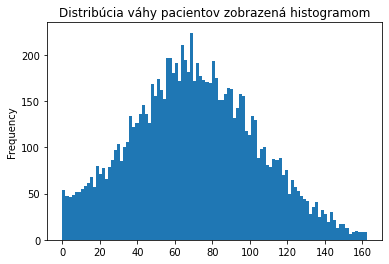

In [31]:
data['weight'] = replace_median(data['weight'])
data['weight'].plot(kind='hist', bins=100).set_title('Distribúcia váhy pacientov zobrazená histogramom')

Po doplnení chýbajúcich hodnôt atribútu **weight** nám zostávajú už len 2 atribúty s chýbajúcimi hodnotami :

In [32]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

HK group         30
weight group    229
dtype: int64

Atribút **weight group** nám označuje len váhovú kategóriu do ktorej patrí váha pacienta, a tak môžme ľahko doplniť chýbajúce hodnoty pomocou funkcie *weight_grouper*

In [33]:
data['weight group'].describe()

count      9679
unique       20
top       60-70
freq       1168
Name: weight group, dtype: object

In [34]:
def weight_grouper(weight):
    w = int(weight / 10)*10
    return str(w) + '-' + str(w+10)
    
data['weight group'] = data['weight'].apply(weight_grouper)

In [35]:
data['weight group'].describe()

count      9908
unique       17
top       60-70
freq       1203
Name: weight group, dtype: object

Môžme vidieť že sme doplnili všetky potrebné záznamy. Podobnú funkciu použijeme aj v prípade **HK group**

In [36]:
data['HK group'].describe()

count     9878
unique      11
top        5-6
freq      2175
Name: HK group, dtype: object

In [37]:
def HK_grouper(HK):
    hk = int(HK)
    return str(hk) + '-' + str(hk+1)
    
data['HK group'] = data['hematokrit'].apply(HK_grouper)

In [38]:
data['HK group'].describe()

count     9908
unique      11
top        5-6
freq      2182
Name: HK group, dtype: object

In [39]:
df=pd.DataFrame({"Priemer predtým":data0.mean(),"Median predtým":data0.median(),"Priemer potom":data.mean(),"Median potom":data.median()})
df

,Priemer predtým,Median predtým,Priemer potom,Median potom
age,57.995357,58.000000,57.995357,58.000000
leukocyty,6.793018,6.993640,6.793814,6.992485
weight,70.635417,69.491150,70.270389,69.319460
hbver,6.793715,6.785165,6.792209,6.784746
er-cv,48.350437,48.300335,48.372967,48.320590
ast,49.307390,49.249260,49.316767,49.249260
indicator,0.645337,1.000000,0.645337,1.000000
hematokrit,6.369656,6.315170,6.371898,6.317320
trombocyty,6.426925,6.337080,6.424931,6.337235
alt,8.945878,7.528915,8.551448,7.538350


V danej tabuľke vidíme výsledok úlohy 1 - nenumerické hodnoty premenené na numerické a odstránenie outlierov.

**uloženie upravenej sady dát** po odstránení outlierov a nahradení chýbajúcich hodnôt

In [40]:
data.to_csv('data/merged_dataset.csv', sep='\t', index=False, encoding='utf-8')

## **Rozdelenie dát na trénovaciu a testovaciu sadu**

In [41]:
data_train, data_test = train_test_split(data, test_size=0.33, random_state = 0)
data_train_zaloha= data_train

Rozdelenie v pomer 67% trénovacia sada a 33% testovacia sada.

## 2. Realizácia predspracovania dát

Odstránenie atribútov, ktoré nie sú laboratórne hodnoty(demografické hodnoty a identifikátory pacienta a pod) teda, nemajú vzťah k premennej indikátor.

In [42]:
data_train = data_train.drop("name",1)
data_train = data_train.drop("job",1)
data_train = data_train.drop("company",1)
data_train = data_train.drop("residence",1)
data_train = data_train.drop("birthdate",1)
data_train = data_train.drop("ssn",1)
data_train = data_train.drop("HK group",1)
data_train = data_train.drop("weight group",1)
data_testzaloha = data_test.drop("name",1)
data_testzaloha = data_test.drop("job",1)
data_testzaloha = data_test.drop("company",1)
data_testzaloha = data_test.drop("residence",1)
data_testzaloha = data_test.drop("birthdate",1)
data_testzaloha = data_test.drop("ssn",1)
data_testzaloha = data_test.drop("HK group",1)
data_testzaloha = data_test.drop("weight group",1)

Demografické atribúty ako job, company a residence sme odstránili, pretože nijako neovplyvňujú zdravotný stav pacienta a netýkajú sa jeho laboratórnych výsledkov.

Atribút ssn a name slúžia len na identifikáciu pozorovania resp. pacienta ku ktorému daný laboratórny záznam patrí, preto sú z hľadiska prieskumnej analýzy resp. strojového učenia nepodstatné.

Atribúty HK group a weight group boli atribúty pridané nami počas EDA v 1. fáze preto ich tiež môžeme odstrániť.

A nespojitý atribút birthdate sme nahradili spojitým atribútom age, ktorý vyjadruje vek pacienta v rokoch a preto birthdate môžme tiež odstrániť.

### Zopakovanie časti prieskumnej analýzy na trénovacej sade

### Počet záznamov a atribútov

In [43]:
print('Počet záznamov : ',data_train.shape[0] , '\nPočet atribútov: ', data.shape[1])

Počet záznamov :  6638 
Počet atribútov:  27


Dataset obsahuje nasledovné atribúty

In [44]:
data_train.columns

Index(['sex', 'blood_group', 'race', 'age', 'leukocyty', 'weight', 'hbver',
       'er-cv', 'ast', 'indicator', 'hematokrit', 'trombocyty', 'smoker',
       'alt', 'etytr', 'erytrocyty', 'hemoglobin', 'alp', 'relationship'],
      dtype='object')

**Dataset už neobsahuje žiadne chýbajúce hodnoty**

In [45]:
data_train.isnull().sum()

sex             0
blood_group     0
race            0
age             0
leukocyty       0
weight          0
hbver           0
er-cv           0
ast             0
indicator       0
hematokrit      0
trombocyty      0
smoker          0
alt             0
etytr           0
erytrocyty      0
hemoglobin      0
alp             0
relationship    0
dtype: int64

**Môžme si všimnúť že dataset obsahuje 0 duplicitných záznamov.**

In [46]:
data_train.duplicated().sum()

0

## Encoding trénovacej sady
Nenumerické kategorické atribúty budeme premienať na numerické pomocou vlastnej funkcie *encode()*. Funkcia najprv zoradí všetky *unique* záznamy v datasete a podľa toho prepisuje záznamy, aby sme zabezpečili že kódovanie bude rovnaké v oboch datasetoch. Funkcia tiež vypíše použité kódovanie.

In [47]:
def encode(data, columns):
    for c in columns:
        answers = list(list(data[c].unique()))
        answers.sort()
        print("Atribut " + str(c) + " :")
        for i in range(len(answers)):
            print(str(answers[i]) + " -> " + str(i))
        data[c] = data[c].apply(lambda x: answers.index(x))
        
    return data

Našu funkciu aplikujeme na všetky potrebné atribúty datasetu :

In [48]:
data_train = encode(data_train, ['blood_group', 'sex', 'smoker', 'race', 'relationship'])
data_testzaloha = encode(data_testzaloha, ['blood_group', 'sex', 'smoker', 'race', 'relationship'])

Atribut blood_group :
A+ -> 0
A- -> 1
AB+ -> 2
AB- -> 3
B+ -> 4
B- -> 5
O+ -> 6
O- -> 7
Atribut sex :
F -> 0
M -> 1
Atribut smoker :
no -> 0
yes -> 1
Atribut race :
Asian -> 0
Black -> 1
Hawaiian -> 2
Indian -> 3
White -> 4
Atribut relationship :
divorced -> 0
married -> 1
nop -> 2
separated -> 3
single -> 4
widowed -> 5
Atribut blood_group :
A+ -> 0
A- -> 1
AB+ -> 2
AB- -> 3
B+ -> 4
B- -> 5
O+ -> 6
O- -> 7
Atribut sex :
F -> 0
M -> 1
Atribut smoker :
no -> 0
yes -> 1
Atribut race :
Asian -> 0
Black -> 1
Hawaiian -> 2
Indian -> 3
White -> 4
Atribut relationship :
divorced -> 0
married -> 1
nop -> 2
separated -> 3
single -> 4
widowed -> 5


### Atribút blood_group

Text(0.5, 1.0, 'Graf zobrazujúci pomer krvných skupín trénovacej sady')

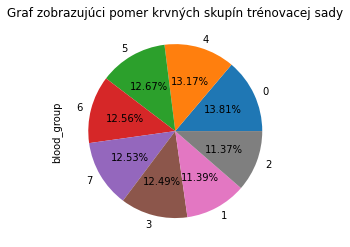

In [49]:
data_train.blood_group.value_counts().plot.pie( autopct='%1.2f%%').set_title('Graf zobrazujúci pomer krvných skupín trénovacej sady')

### Atribút sex

Text(0.5, 1.0, 'Graf zobrazujúci rozdelenie pohlavia trénovacej sady')

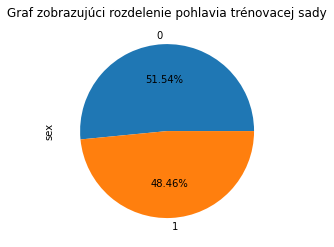

In [50]:
data_train.sex.value_counts().plot.pie( autopct='%1.2f%%').set_title('Graf zobrazujúci rozdelenie pohlavia trénovacej sady')

### Atribút smoker

Text(0.5, 1.0, 'Graf zobrazujúci pomer nefajčiarov a fajčiarov trénovacej sady')

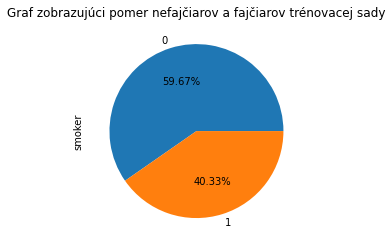

In [51]:
data_train.smoker.value_counts().plot.pie( autopct='%1.2f%%').set_title('Graf zobrazujúci pomer nefajčiarov a fajčiarov trénovacej sady')

### Atribút race

Text(0.5, 1.0, 'Graf zobrazujúci pomer rasových skupín trénovacej sady')

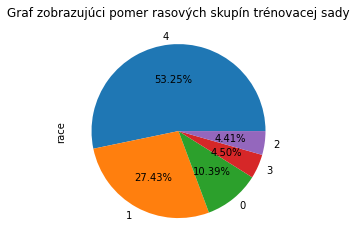

In [52]:
data_train.race.value_counts().plot.pie( autopct='%1.2f%%').set_title('Graf zobrazujúci pomer rasových skupín trénovacej sady')

### Atribút relationship

Text(0.5, 1.0, 'Graf zobrazujúci pomer vzťahov trénovacej sady')

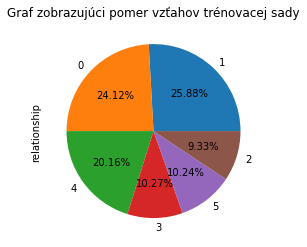

In [53]:
data_train.relationship.value_counts().plot.pie( autopct='%1.2f%%').set_title('Graf zobrazujúci pomer vzťahov trénovacej sady')

## Koniec  encodingu

Encoding nám umožnil transformovať nenumerické dáta na numerické teda na typ dát, ktorý je použiteľný pre strojové učenie

In [54]:
data_train_with_i = data_train
y_train = data_train['indicator']
data_train = data_train.drop('indicator',1)
print()

Rozdelenie datasetov na trénovaciu a testovaciu sadu v pomere 33% je veľkosť testovacej sady a 67% je veľkosť trénovacej sady.

In [55]:
data_test.describe()

,age,leukocyty,weight,hbver,er-cv,ast,indicator,hematokrit,trombocyty,alt,etytr,erytrocyty,hemoglobin,alp
count,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000
mean,58.692661,6.806497,70.544271,6.782760,48.103623,49.126323,0.649235,6.396506,6.425671,8.465333,6.011415,6.803910,6.792051,68.602695
std,33.379746,1.523610,33.392840,0.963766,13.599436,12.214892,0.477282,1.612702,1.685633,3.873955,1.339131,0.948290,0.987371,19.047353
min,0.000000,2.106530,0.117690,4.122870,10.546900,14.778780,0.000000,1.743210,1.586720,3.712878,3.823988,4.148860,4.079350,24.037958
25%,30.000000,5.630587,47.079380,6.091760,38.891328,40.766433,0.000000,5.178525,5.209060,5.714945,5.057202,6.150093,6.098047,57.582488
50%,59.000000,7.007315,69.319460,6.783560,48.332310,49.149685,1.000000,6.343855,6.343380,7.543570,5.898980,6.805395,6.785680,75.290755
75%,88.000000,8.014568,93.751593,7.439317,57.391967,57.662440,1.000000,7.621975,7.610795,10.092208,6.821563,7.456575,7.483672,83.560155
max,116.000000,10.690800,161.777350,9.454670,86.306530,83.920060,1.000000,10.841750,11.256180,18.926994,8.874401,9.493170,9.435580,89.688798


In [56]:
data_train_with_i.describe()

,sex,blood_group,race,age,leukocyty,weight,hbver,er-cv,ast,indicator,hematokrit,trombocyty,smoker,alt,etytr,erytrocyty,hemoglobin,alp,relationship
count,6638.000000,6638.000000,6638.00000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.000000,6638.00000
mean,0.484634,3.507382,2.62790,57.651853,6.787566,70.135469,6.796863,48.505651,49.410583,0.643417,6.359776,6.424566,0.403284,8.593869,6.022931,6.804285,6.795108,68.978161,2.07201
std,0.499801,2.308807,1.57208,33.158670,1.520285,32.898276,0.967707,13.742355,12.396104,0.479026,1.574346,1.712106,0.490594,3.972208,1.353564,0.980207,0.980819,19.057932,1.74637
min,0.000000,0.000000,0.00000,0.000000,2.115950,0.062440,4.091680,10.444020,14.749830,0.000000,1.635650,1.667580,0.000000,3.712878,3.823988,4.104700,4.096550,24.037958,0.00000
25%,0.000000,1.000000,1.00000,29.000000,5.613283,47.174645,6.144275,39.182688,40.753957,0.000000,5.177815,5.191125,0.000000,5.735012,5.042375,6.136497,6.122485,58.505063,1.00000
50%,0.000000,4.000000,4.00000,57.000000,6.983955,69.319460,6.785165,48.315950,49.336300,1.000000,6.309455,6.332960,0.000000,7.537690,5.852230,6.807040,6.784535,75.654720,1.50000
75%,1.000000,6.000000,4.00000,87.000000,8.014200,92.805472,7.463667,58.032430,57.854237,1.000000,7.564443,7.638848,1.000000,10.298832,6.862275,7.485087,7.451925,83.800935,4.00000
max,1.000000,7.000000,4.00000,116.000000,10.423140,162.347770,9.466650,86.434280,83.873210,1.000000,11.187870,11.278320,1.000000,18.926994,8.874401,9.483150,9.473200,89.688798,5.00000


Oba datasety po rozdelení obsahujú dáta s takmer rovnakými charakteristikami vynímajúc odstránené atribúty z trénovacej sady a encoding kategorických hodnôť v trénovacej sade. Trénovací dataset obsahuje 6638 záznamov a testovací dataset obsahuje 3270 záznamov.

**Škálovanie dát**

Škálovanie atribútov je metóda na obmedzenie rozsahu daných atribútov, aby sa dali lepšie vzájomne porovnávať. Pretože ak majú atribúty rôzne rozsahy môžu nastať pri klasifikácií modelom nasledujúce problémy:

    1. nestabilný alebo slabý výkon modelu
    2. zvýšená citlivosť na vstupy
    3. vyššia chyba zovšeobecnenia

Ako sme vidieli pri data_train.describe() rosahy jednotlivých atribútov sú relatívne rôznorodé. Preto sa rozhodneme dané dáta preškálovať. Definujeme si jednoduchú funkciu na škálovanie :

In [59]:
def data_scaler(dataset, atributes):
    scaler =  StandardScaler()
    dataset[atributes] = scaler.fit_transform(dataset[atributes])
    return dataset

In [60]:
data_train = data_scaler(data_train, ['age','leukocyty','weight','hbver','er-cv','ast','hematokrit','trombocyty','alt','etytr','erytrocyty','hemoglobin','alp'])

Preškálujeme spojité atribúty datasetu: age, leukocyty, weight, hbver, er-cv, ast, hematokrit, trombocyty, alt, etytr, erytrocyty, hemoglobin, alp

In [61]:
data_train.describe()

,sex,blood_group,race,age,leukocyty,weight,hbver,er-cv,ast,hematokrit,trombocyty,smoker,alt,etytr,erytrocyty,hemoglobin,alp,relationship
count,6638.000000,6638.000000,6638.00000,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6638.000000,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6638.00000
mean,0.484634,3.507382,2.62790,2.354917e-17,2.890126e-17,-2.100693e-17,1.016896e-17,-9.098544e-18,-3.398574e-17,-1.391542e-17,-8.563335e-18,0.403284,-1.391542e-17,3.211251e-18,-4.816876e-18,3.746459e-18,-7.492918e-18,2.07201
std,0.499801,2.308807,1.57208,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,0.490594,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.74637
min,0.000000,0.000000,0.00000,-1.738797e+00,-3.073087e+00,-2.130151e+00,-2.795667e+00,-2.769867e+00,-2.796311e+00,-3.000918e+00,-2.778650e+00,0.000000,-1.228878e+00,-1.624680e+00,-2.754303e+00,-2.751539e+00,-2.358262e+00,0.00000
25%,0.000000,1.000000,1.00000,-8.641484e-01,-7.724684e-01,-6.979865e-01,-6.744161e-01,-6.784621e-01,-6.983870e-01,-7.508196e-01,-7.204775e-01,0.000000,-7.197690e-01,-7.244798e-01,-6.813231e-01,-6.858286e-01,-5.495815e-01,1.00000
50%,0.000000,4.000000,4.00000,-1.966008e-02,1.291886e-01,-2.480588e-02,-1.208931e-02,-1.380518e-02,-5.992877e-03,-3.196523e-02,-5.350893e-02,0.000000,-2.659123e-01,-1.261215e-01,2.810741e-03,-1.078061e-02,3.503561e-01,1.50000
75%,1.000000,6.000000,4.00000,8.851488e-01,8.069053e-01,6.891459e-01,6.891081e-01,6.932943e-01,6.812052e-01,7.652435e-01,7.092860e-01,1.000000,4.292553e-01,6.201465e-01,6.946017e-01,6.697122e-01,7.778331e-01,4.00000
max,1.000000,7.000000,4.00000,1.759797e+00,2.391556e+00,2.803164e+00,2.759087e+00,2.760188e+00,2.780327e+00,3.066962e+00,2.835174e+00,1.000000,2.601551e+00,2.106798e+00,2.733163e+00,2.730671e+00,1.086802e+00,5.00000


In [62]:
data_testzaloha.describe()

,sex,blood_group,race,age,leukocyty,weight,hbver,er-cv,ast,indicator,hematokrit,trombocyty,smoker,alt,etytr,erytrocyty,hemoglobin,alp,relationship
count,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000
mean,0.491131,3.518043,2.595413,58.692661,6.806497,70.544271,6.782760,48.103623,49.126323,0.649235,6.396506,6.425671,0.395719,8.465333,6.011415,6.803910,6.792051,68.602695,2.050459
std,0.499998,2.308193,1.583191,33.379746,1.523610,33.392840,0.963766,13.599436,12.214892,0.477282,1.612702,1.685633,0.489079,3.873955,1.339131,0.948290,0.987371,19.047353,1.727247
min,0.000000,0.000000,0.000000,0.000000,2.106530,0.117690,4.122870,10.546900,14.778780,0.000000,1.743210,1.586720,0.000000,3.712878,3.823988,4.148860,4.079350,24.037958,0.000000
25%,0.000000,2.000000,1.000000,30.000000,5.630587,47.079380,6.091760,38.891328,40.766433,0.000000,5.178525,5.209060,0.000000,5.714945,5.057202,6.150093,6.098047,57.582488,1.000000
50%,0.000000,4.000000,4.000000,59.000000,7.007315,69.319460,6.783560,48.332310,49.149685,1.000000,6.343855,6.343380,0.000000,7.543570,5.898980,6.805395,6.785680,75.290755,2.000000
75%,1.000000,6.000000,4.000000,88.000000,8.014568,93.751593,7.439317,57.391967,57.662440,1.000000,7.621975,7.610795,1.000000,10.092208,6.821563,7.456575,7.483672,83.560155,4.000000
max,1.000000,7.000000,4.000000,116.000000,10.690800,161.777350,9.454670,86.306530,83.920060,1.000000,10.841750,11.256180,1.000000,18.926994,8.874401,9.493170,9.435580,89.688798,5.000000


Ako vidíme rozsah spojitých atribútov sa zmenil avšak škálovanie by malo zachovať ich distribúcie.

**Transformovanie spojitých dát aby boli do štandardného rozdelenia**

Vo všeobecnosti algortimu strojového učenia dosahujú väčšiu mieru úspešnosti, ak sú dáta zo štandarného resp. normálneho rozdelenia, preto je vhodné dáta upraviť do takéhoto tvaru, skontrolujeme teda rozdelenie jednotlivých atribútov a v prípade, že nie sú z normálneho rozdelenia ich budeme normalizovať. Keďže po preškálovaní dát nadobúdajú dané spojité premenné aj záporné hodnoty ak premenná nebude z normálneho rozdelenia, budeme aplikovať **Yeo-Johnson power transformer, lebo funguje aj pre kladné aj záporné hodnoty.**

**Atribút age**

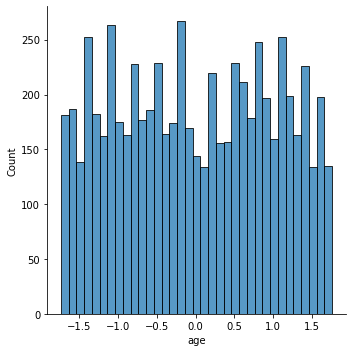

In [63]:
sns.displot(data_train, x="age", binwidth=0.1)

Na základe grafu distribúcie atribútu age predpokladáme, že tento atribút nie je z normálneho rozdelenia. Preto použijeme **power transform metódu** na normalizáciu dát.

In [64]:
def data_transform(data):
    d = exp(data.to_numpy())

    d = d.reshape((len(d),1))

    power = PowerTransformer(method='yeo-johnson', standardize=True) 
    data_trans = power.fit_transform(d)
    return data_trans

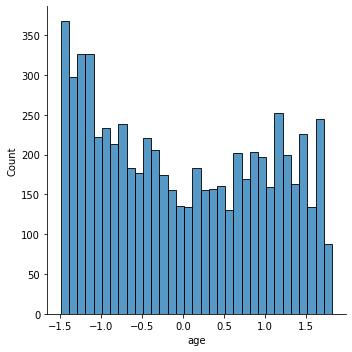

In [65]:
data_train.age = data_transform(data_train.age)
sns.displot(data_train.age, binwidth=0.1)

Vidíme, že distribúcia dát je o niečo lepšia, ale stále nie z normálneho rozdelenia.

**Atribút leukocyty**

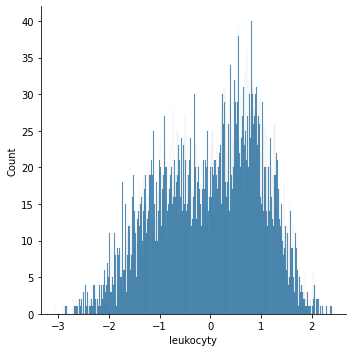

In [66]:
sns.displot(data_train, x="leukocyty", binwidth=0.01)

Na základe grafu distribúcie atribútu leukocyty predpokladáme, že tento atribút je z normálneho rozdelenia avšak poďme náš predpoklad overiť štatistickým testom.

In [67]:
print("Vykonajme štatistické testy normálnosti rozdelenia dát")
print("Ak bude pvalue > ako 0,05 tak nezamietame H0, a teda predpokladáme, že dáta sú z normálneho rozdelenia")
print("")

stat, p = stats.shapiro(data_train.leukocyty)
print('Statistics=%.3f, p=%s' % (stat, str(p)))
alpha = 0.05
print("Shapirov test normálnosti dát")
if p > alpha:
	print('Dáta sú pravdepodobne z normálneho - Gaussovho rozdelenia (neodmietame H0)')
else:
	print('Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)')
    
print("")
print("D’Agostino’s K^2 test normálnosti dát")   
stat, p = normaltest(data_train.leukocyty)
print('Statistics=%.3f, p=%s' % (stat, str(p)))
alpha = 0.05
if p > alpha:
	print('Dáta sú pravdepodobne z normálneho - Gaussovho rozdelenia (neodmietame H0)')
else:
	print('Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)')

Vykonajme štatistické testy normálnosti rozdelenia dát
Ak bude pvalue > ako 0,05 tak nezamietame H0, a teda predpokladáme, že dáta sú z normálneho rozdelenia

Statistics=0.979, p=6.206243794262414e-30
Shapirov test normálnosti dát
Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)

D’Agostino’s K^2 test normálnosti dát
Statistics=478.613, p=1.17610176637939e-104
Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)


Na základe štatistického testu sme zistili, že distribúcia tohto atribútu nepochádza z normálneho rozdelenia. Preto použijeme **power transform metódu** na normalizáciu dát.

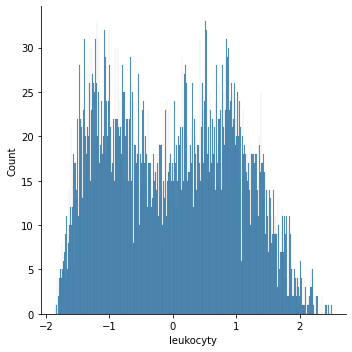

In [68]:
data_train.leukocyty = data_transform(data_train.leukocyty)
sns.displot(data_train.leukocyty, binwidth=0.01)

Na grafe distribúcie atribútu leukocyty pozorujeme zmenu v hodnotách atribútu leukocyty a rovnako aj istú mieru normalizácie hodnôt tohto atribútu voči predchádzajúcemu stavu.

**Atribút weight**

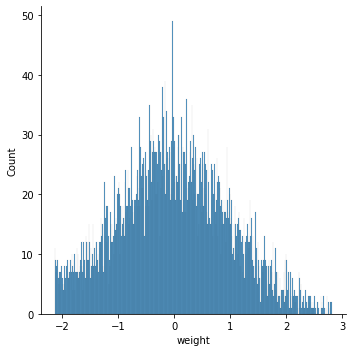

In [69]:
sns.displot(data_train, x="weight", binwidth=0.01)

Na základe grafu distribúcie atribútu weight predpokladáme, že tento atribút je z normálneho rozdelenia avšak poďme náš predpoklad overiť štatistickým testom.

In [70]:
print("Vykonajme štatistické testy normálnosti rozdelenia dát")
print("Ak bude pvalue > ako 0,05 tak nezamietame H0, a teda predpokladáme, že dáta sú z normálneho rozdelenia")
print("")

stat, p = stats.shapiro(data_train.weight)
print('Statistics=%.3f, p=%s' % (stat, str(p)))
alpha = 0.05
print("Shapirov test normálnosti dát")
if p > alpha:
	print('Dáta sú pravdepodobne z normálneho - Gaussovho rozdelenia (neodmietame H0)')
else:
	print('Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)')
    
print("")
print("D’Agostino’s K^2 test normálnosti dát")   
stat, p = normaltest(data_train.weight)
print('Statistics=%.3f, p=%s' % (stat, str(p)))
alpha = 0.05
if p > alpha:
	print('Dáta sú pravdepodobne z normálneho - Gaussovho rozdelenia (neodmietame H0)')
else:
	print('Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)')

Vykonajme štatistické testy normálnosti rozdelenia dát
Ak bude pvalue > ako 0,05 tak nezamietame H0, a teda predpokladáme, že dáta sú z normálneho rozdelenia

Statistics=0.994, p=3.5240988411994417e-16
Shapirov test normálnosti dát
Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)

D’Agostino’s K^2 test normálnosti dát
Statistics=92.907, p=6.692729172330831e-21
Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)


Na základe štatistického testu sme zistili, že distribúcia tohto atribútu nepochádza z normálneho rozdelenia. Preto použijeme **power transform metódu** na normalizáciu dát.

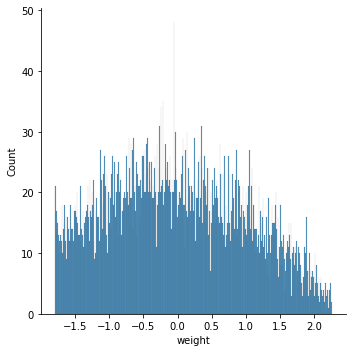

In [71]:
data_train.weight = data_transform(data_train.weight)
sns.displot(data_train.weight, binwidth=0.01)

Na grafe distribúcie atribútu weight pozorujeme zmenu v hodnotách atribútu weight a rovnako aj istú mieru normalizácie hodnôt tohto atribútu voči predchádzajúcemu stavu.

**Atribút hbver**

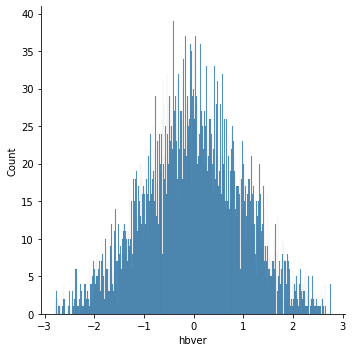

In [72]:
sns.displot(data_train, x="hbver", binwidth=0.01)

Na základe grafu distribúcie atribútu hbver predpokladáme, že tento atribút je z normálneho rozdelenia.

**Atribút er-cv**

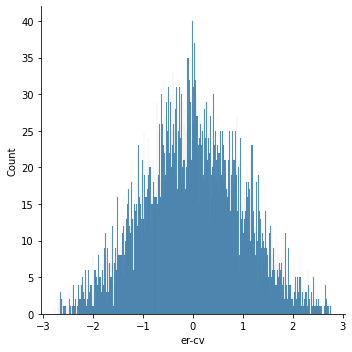

In [73]:
sns.displot(data_train, x="er-cv", binwidth=0.01)

Na základe grafu distribúcie atribútu er-cv predpokladáme, že tento atribút je z normálneho rozdelenia.

**Atribút ast**

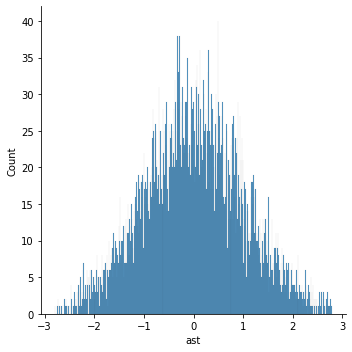

In [74]:
sns.displot(data_train, x="ast", binwidth=0.01)

Na základe grafu distribúcie atribútu ast predpokladáme, že tento atribút je z normálneho rozdelenia avšak poďme náš predpoklad overiť štatistickým testom.

In [75]:
print("Vykonajme štatistické testy normálnosti rozdelenia dát")
print("Ak bude pvalue > ako 0,05 tak nezamietame H0, a teda predpokladáme, že dáta sú z normálneho rozdelenia")
print("")

stat, p = stats.shapiro(data_train.ast)
print('Statistics=%.3f, p=%s' % (stat, str(p)))
alpha = 0.05
print("Shapirov test normálnosti dát")
if p > alpha:
	print('Dáta sú pravdepodobne z normálneho - Gaussovho rozdelenia (neodmietame H0)')
else:
	print('Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)')
    
print("")
print("D’Agostino’s K^2 test normálnosti dát")   
stat, p = normaltest(data_train.ast)
print('Statistics=%.3f, p=%s' % (stat, str(p)))
alpha = 0.05
if p > alpha:
	print('Dáta sú pravdepodobne z normálneho - Gaussovho rozdelenia (neodmietame H0)')
else:
	print('Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)')

Vykonajme štatistické testy normálnosti rozdelenia dát
Ak bude pvalue > ako 0,05 tak nezamietame H0, a teda predpokladáme, že dáta sú z normálneho rozdelenia

Statistics=0.998, p=1.0691683201002888e-06
Shapirov test normálnosti dát
Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)

D’Agostino’s K^2 test normálnosti dát
Statistics=27.148, p=1.273003719859435e-06
Dáta pravdepodobne nie sú z normálneho - Gaussovho rozdelenia (odmietame H0)


Na základe štatistického testu sme zistili, že distribúcia tohto atribútu nepochádza z normálneho rozdelenia. Preto použijeme **power transform metódu** na normalizáciu dát.

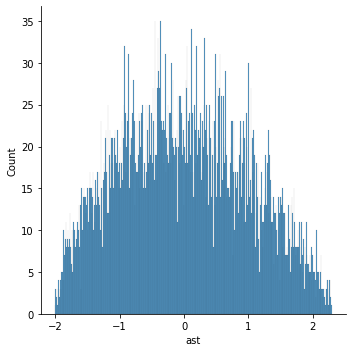

In [76]:
data_train.ast = data_transform(data_train.ast)
sns.displot(data_train.ast, binwidth=0.01)

Na grafe distribúcie atribútu ast pozorujeme zmenu v hodnotách atribútu ast a rovnako aj istú mieru normalizácie hodnôt tohto atribútu voči predchádzajúcemu stavu.

**Atribút hematokrit**

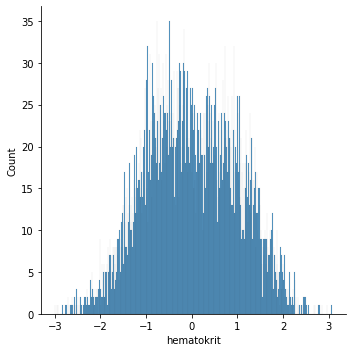

In [77]:
sns.displot(data_train, x="hematokrit", binwidth=0.01)

Na základe grafu distribúcie atribútu hematokrit predpokladáme, že tento atribút je z normálneho rozdelenia.

**Atribút trombocyty**

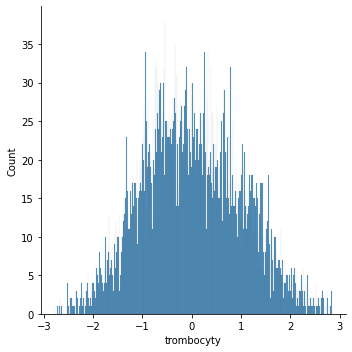

In [78]:
sns.displot(data_train, x="trombocyty", binwidth=0.01)

Na základe grafu distribúcie atribútu trombocyty predpokladáme, že tento atribút je z normálneho rozdelenia.

**Atribút alt**

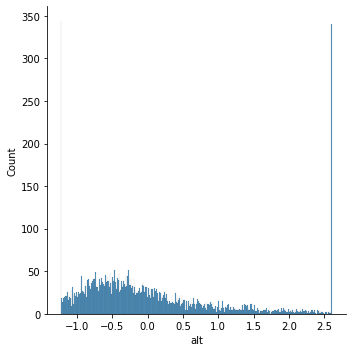

In [79]:
sns.displot(data_train, x="alt", binwidth=0.01)

Na základe grafu predpokladáme, že distribúcia tohto atribútu nepochádza z normálneho rozdelenia. Preto použijeme **power transform metódu** na normalizáciu dát.

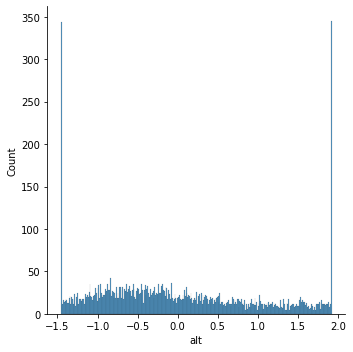

In [80]:
data_train.alt = data_transform(data_train.alt)
sns.displot(data_train.alt, binwidth=0.01)

Na grafe distribúcie atribútu alt pozorujeme zmenu v hodnotách atribútu alt a rovnako aj istú mieru normalizácie hodnôt tohto atribútu voči predchádzajúcemu stavu.

**Atribút etytr**

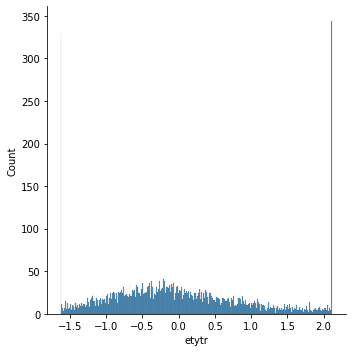

In [81]:
sns.displot(data_train, x="etytr", binwidth=0.01)

Na základe grafu predpokladáme, že distribúcia tohto atribútu nepochádza z normálneho rozdelenia. Preto použijeme **power transform metódu** na normalizáciu dát.

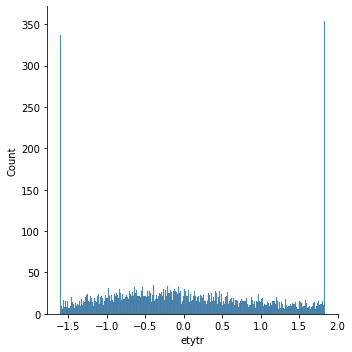

In [82]:
data_train.etytr = data_transform(data_train.etytr)
sns.displot(data_train.etytr, binwidth=0.01)

Na grafe distribúcie atribútu etytr pozorujeme zmenu v hodnotách atribútu etytr a rovnako aj istú mieru normalizácie hodnôt tohto atribútu voči predchádzajúcemu stavu.

**Atribút erytrocyty**

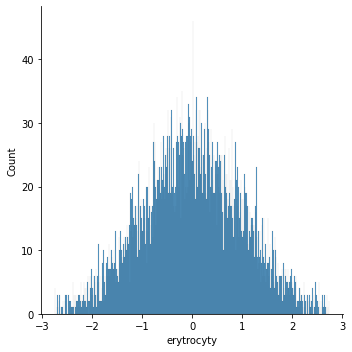

In [83]:
sns.displot(data_train, x="erytrocyty", binwidth=0.01)

Na základe grafu distribúcie atribútu erytrocyty predpokladáme, že tento atribút je z normálneho rozdelenia.

**Atribút hemoglobin**

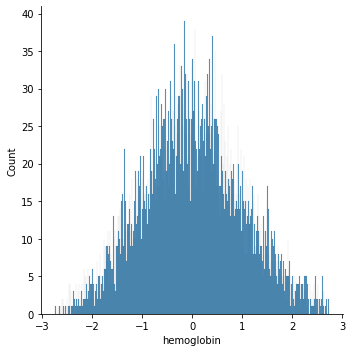

In [84]:
sns.displot(data_train, x="hemoglobin", binwidth=0.01)

Na základe grafu distribúcie atribútu hemoglobin predpokladáme, že tento atribút je z normálneho rozdelenia.

**Atribút alp**

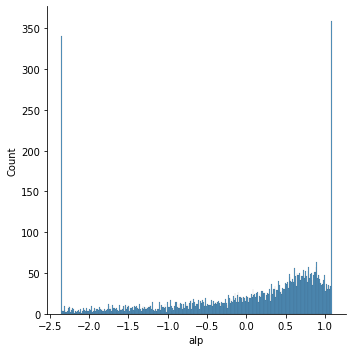

In [85]:
sns.displot(data_train, x="alp", binwidth=0.01)

Na základe grafu predpokladáme, že distribúcia tohto atribútu nepochádza z normálneho rozdelenia. Preto použijeme **power transform metódu** na normalizáciu dát.

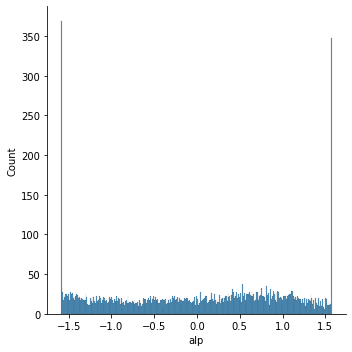

In [86]:
data_train.alp = data_transform(data_train.alp)
sns.displot(data_train.alp, binwidth=0.01)

Na grafe distribúcie atribútu alp pozorujeme zmenu v hodnotách atribútu alp a rovnako aj istú mieru normalizácie hodnôt tohto atribútu voči predchádzajúcemu stavu.

## 3. Výber atribútov pre strojové učenie

### Analyzujme dáta a pokúsme sa identifikovať atribúty ktoré budú významné pre strojové učenie.

Chceme urobiť výber podmnožiny vstupných atribútov pre model z atribútov ktoré sú najrelevantnejšie pre odhadnutie hodnoty cieľového atribútu(indicator).
Tento proces umožní zredukovať počet atribútov vstupujúcich do modelu čo vedie k lepšej presnosti modelu(znižuje mieru overfittingu) a aj vyššej výkonnosti(predikčnej rýchlosti) modelu.

### Výberové techniky typu filter:

**1. Pearsonova korelácia**

Náhľad na vzťahy medzi jednotlivými atribútmi pomocou heatmapy

Text(0.5, 1.0, 'Heatmapa zobrazuje hodnoty korelácie jednotlivých atribútov')

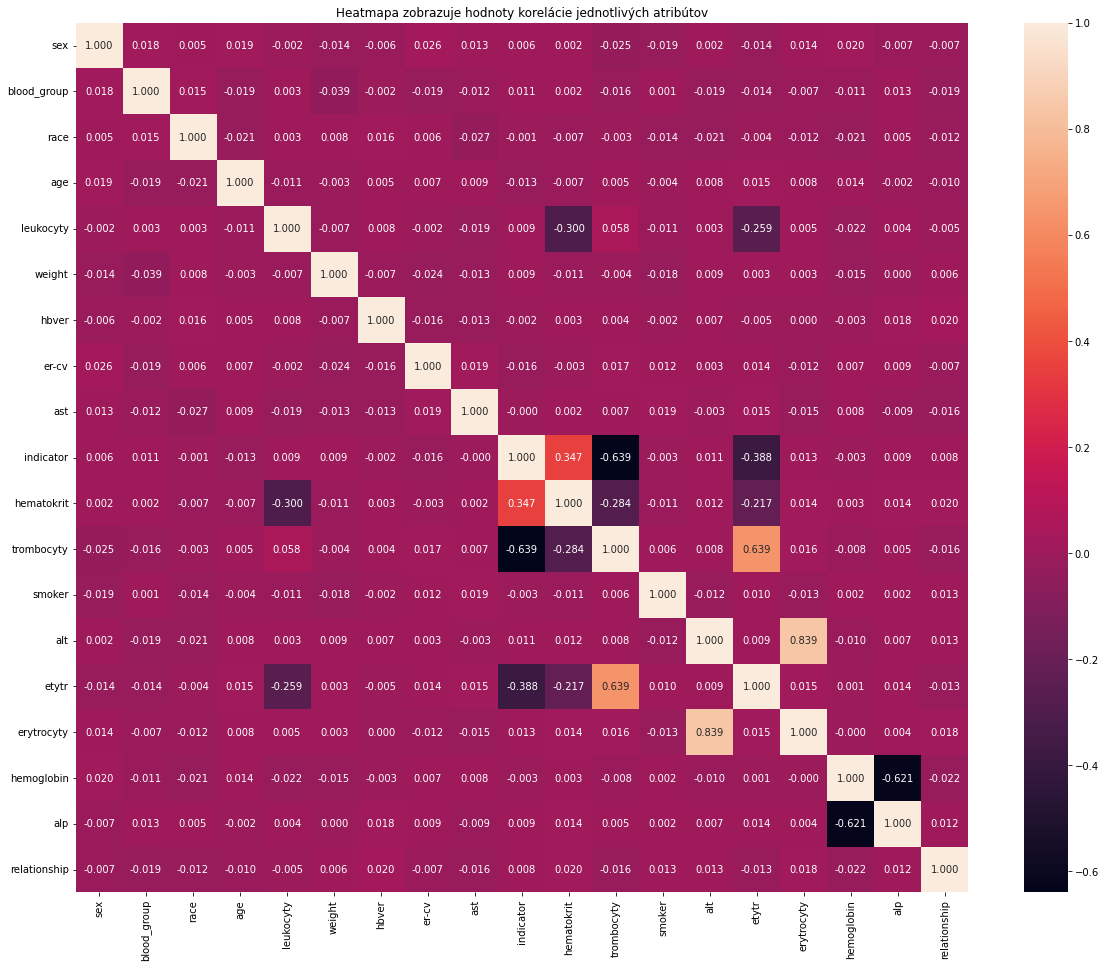

In [87]:
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(data_train_with_i.dropna().corr(),ax=ax, annot =True, fmt = ".3f").set_title('Heatmapa zobrazuje hodnoty korelácie jednotlivých atribútov')

Pozrime sa teda aké sú najviac korelované atribúty s atribútom indikátor a aké sú miery ich korelácie.

In [88]:
def corelation_selector(data, predicted_atribute, top_n_atributes):
    atribute_name = data.columns.tolist()
    corelations = data[data.columns[1:]].corr()[predicted_atribute][:]
    sorted = corelations.iloc[(-corelations.abs()).argsort()]
    return sorted[1:top_n_atributes+1]
   
correlation_data = corelation_selector(data_train_with_i,"indicator",5)
print(correlation_data, '5 najviac korelovaných atribútov s atribútom indikátor a miera ich korelácie')

trombocyty   -0.639443
etytr        -0.388317
hematokrit    0.346574
er-cv        -0.016454
erytrocyty    0.013420
Name: indicator, dtype: float64 5 najviac korelovaných atribútov s atribútom indikátor a miera ich korelácie


**Zoradenie atribútov podľa dôležitosti pre určenie hodnoty predikovanej premennej na základe veľkosti ich korelácie od najdôležitejšieho:**

    1. trombocyty
    2. hematokrit
    3. etytr

In [89]:
correlation_data = corelation_selector(data_train_with_i,"hematokrit",5)
print(correlation_data, '5 najviac korelovaných atribútov s atribútom hematokrit a miera ich korelácie')

indicator       0.346574
leukocyty      -0.300060
trombocyty     -0.283926
etytr          -0.217364
relationship    0.020173
Name: hematokrit, dtype: float64 5 najviac korelovaných atribútov s atribútom hematokrit a miera ich korelácie


In [90]:
correlation_data = corelation_selector(data_train_with_i,"trombocyty",5)
print(correlation_data, '5 najviac korelovaných atribútov s atribútom trombocyty a miera ich korelácie')

indicator    -0.639443
etytr         0.638974
hematokrit   -0.283926
leukocyty     0.058081
er-cv         0.017078
Name: trombocyty, dtype: float64 5 najviac korelovaných atribútov s atribútom trombocyty a miera ich korelácie


In [91]:
correlation_data = corelation_selector(data_train_with_i,"etytr",5)
print(correlation_data, '5 najviac korelovaných atribútov s atribútom etytr a miera ich korelácie')

trombocyty    0.638974
indicator    -0.388317
leukocyty    -0.258947
hematokrit   -0.217364
ast           0.015334
Name: etytr, dtype: float64 5 najviac korelovaných atribútov s atribútom etytr a miera ich korelácie


**Zistenia zo štatistickej filtrovacej techniky (pearsonovej korelácie) výberu významných atribútov pre strojové učenie:**

    Medzi atribúty datasetu, ktoré majú väčšíu ako veľmi nízku mieru korelácie s atribútom indicator a teda sú ich hodnoty pravdepodobne vzájomne závislé, patria atribúty:
    1. etytr
    2. trombocyty
    3. hematokrit
    Zároveň atribút leukocyty je vo vzťahu(je korelovaný) s atribútmi:
    1. hematokrit
    2. etytr
    3. trombocyty
    preto predpokladáme, že bude tiež významný pri určovaní hodnoty indikátora, tento predpoklad overíme v ďalších testoch.

Kedže medzi hodnotami spomenutých 4 atribútov(**etytr, trombocyty, hematokrit, leukocyty**) existuje vzťah s hodnotami predikovaného atribútu **indicator** tieto nás pri klasifikácií búdú zaujímať najviac na základe tohto filtrovacieho kritéria identifikácie podstatných čŕt v dátach. 

**3. Využijeme tzv. metódu Mutual Information**

In [92]:
X_new = SelectKBest(mutual_info_regression, k=5).fit(data_train, y_train)
method_result = X_new.get_support()
chi_feature = data_train.loc[:,method_result].columns.tolist()
print('vybraných 5 najvýznamnejších atribútov podľa metódy mutual information')
chi_feature

vybraných 5 najvýznamnejších atribútov podľa metódy mutual information


['hbver', 'hematokrit', 'trombocyty', 'smoker', 'etytr']

**4. Využijeme tzv. metódu f_regression resp F anova**

In [93]:
X_new = SelectKBest(f_regression, k=5).fit(data_train, y_train)
method_result = X_new.get_support()
f_feature = data_train.loc[:,method_result].columns.tolist()
print('vybraných 5 najvýznamnejších atribútov podľa metódy f regression')
f_feature

vybraných 5 najvýznamnejších atribútov podľa metódy f regression


['age', 'er-cv', 'hematokrit', 'trombocyty', 'etytr']

### Výberové techniky typu wrapper:

**1. RFE - recursive feature elimination s použitím Rozhodovacieho stromu**

Využitie klasifikátora typu rozhodovací strom - DecisionTreeClassifier s rôznym počtom a typom vstupných atribútov tohto modelu pre porovnanie, toho aké úspešnosti je daný model schopný dosiahnuť vzhľadom na atribúty na základe ktorých predikuje hodnotu premennej indikátor. Na základe úspešnosti jednotlivých modelov sme určili, ktoré atribúty sú najvýznamnejšie pri predikovaní premennej indikátor. Najúspešnejší model(tohto typu) využíval na predikovanie premennej indikátor niekoľko atribútov a to okrem iných opäť atribúty  **trombocyty, leukocyty, hematokrit a etytr**. V tomto prípade vyberáme dôležité atribúty na základe toho, koľkokrát sa alg. strojového učenia pri klasifikovaní rozhodoval na základe hodnoty tohto atribútu.

V závislosti od rozdelenia datasetov na trénovaciu a testovaciu sadu sa niekedy líši počet optimálnych atribútov pre daný model a rovnako aj ich rozloženie a celková úspešnosť modelu. Avšak pri všetkých nami doposial testovaných spusteniach najúspešnejší model vždy využíval minimálne 4 atribúty a tieto vždy obsahovali trombocyty, leukocyty, hematokrit a etytr.

In [94]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

X = data_train
y = y_train
cols = list(X.columns)

nof_list=np.arange(1,len(cols))            
nof=0       
high_score=0
score_list =[]

for n in range(len(nof_list)):
    X_train, X_test, y_trainloc, y_testloc = train_test_split(X,y, test_size = 0.3, random_state = 0)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_trainloc)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_trainloc)
    score = model.score(X_test_rfe,y_testloc)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

optimal_number_of_features = nof

print("Optimálny počet sledovaných atribútov pre strojové učenie",nof)

rfe = RFE(model, optimal_number_of_features)  
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index


print("Optimálne atribúty pre strojové učenie podľa wrapper metódy",selected_features_rfe)
print('Úspešnosť modelu: %s typu rozhodovací strom(DecisionTreeClassifier), ktorý na predikovanie hodnoty indicator využíval tieto atribúty' % (str(high_score)))
for i in range(X.shape[1]):
	print('Atribút: %s, Vybraný modelom pri klasifikácií: %s, Poradie významnosti atribútu: %.1f' % (X.columns[i], rfe.support_[i], rfe.ranking_[i]))

#výsledný zdrojový kód je upravený kód zo stránok 
#zdroj a teória kódu: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
#zdroj a teória kódu: https://machinelearningmastery.com/rfe-feature-selection-in-python/

Optimálny počet sledovaných atribútov pre strojové učenie 8
Optimálne atribúty pre strojové učenie podľa wrapper metódy Index(['age', 'leukocyty', 'weight', 'hematokrit', 'trombocyty', 'etytr',
       'erytrocyty', 'hemoglobin'],
      dtype='object')
Úspešnosť modelu: 0.9076305220883534 typu rozhodovací strom(DecisionTreeClassifier), ktorý na predikovanie hodnoty indicator využíval tieto atribúty
Atribút: sex, Vybraný modelom pri klasifikácií: False, Poradie významnosti atribútu: 10.0
Atribút: blood_group, Vybraný modelom pri klasifikácií: False, Poradie významnosti atribútu: 8.0
Atribút: race, Vybraný modelom pri klasifikácií: False, Poradie významnosti atribútu: 9.0
Atribút: age, Vybraný modelom pri klasifikácií: True, Poradie významnosti atribútu: 1.0
Atribút: leukocyty, Vybraný modelom pri klasifikácií: True, Poradie významnosti atribútu: 1.0
Atribút: weight, Vybraný modelom pri klasifikácií: True, Poradie významnosti atribútu: 1.0
Atribút: hbver, Vybraný modelom pri klasifikácií:

Medzi atribúty datasetu, ktoré využíval najúspešnejší klasifikátor(DecisionTreeClassifier) patrili:
   
    1. leukocyty
    2. hematokrit
    3. trombocyty
    4. etytr
    
Tento typ klasifikačného modelu dosiahol klasifikačnú presnosť atribútu indicator na základe kombinácie daných atribútov až na úrovni okolo 90%. Rovnako na základe poradia významnosti atribútov(hodnota 1 je najvýznamnejší atribút), možno predpokladať, že rovnako ako pre Pearsonovu koreláciu aj tu sú okrem iných atribúty **trombocyty, leukocyty, hematokrit a etytr** sú klúčové atribúty datasetu pre predikovanie hodnoty indikátora.

### Výberové techniky typu embedded:

**1. Lasso technika**

Technika lasso je vhodná pre výber významných atribútov vzhľadom na ich dôležiťosť pri predikovaní hondoty predikovanje premennej. Atribúty, ktoré majú hodnotu Lasso resp. koeficientu významnosti rovnú 0 alebo veľmi blízku 0 sú atribúty, ktoré sú nevýznamné pri predikovaní hodnoty predikovanej premennej. Naopak atribútych, ktorých koeficient významnosti je v absolútnej hodnote čo najväčší sú významné pri predikovaní hondoty predikovanej premennej.

Text(0.5, 1.0, 'Dôležitosť jednotlivých atribútov s využitím lasso techniky')

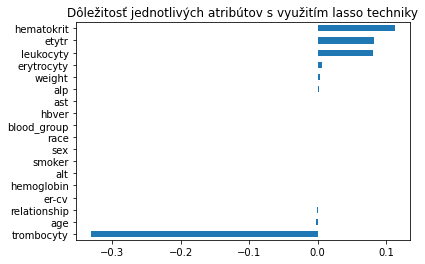

In [95]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(data_train, y_train)
coef = pd.Series(reg.coef_, index = X.columns)
importance_coefficient = coef.sort_values()
importance_coefficient.plot(kind = "barh")
plt.title("Dôležitosť jednotlivých atribútov s využitím lasso techniky")
#zdroj: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

Na základe aplikovania Lasso techniky opäť z grafu vidíme, že atribúty ktoré sú dôležité pre  **trombocyty, leukocyty, hematokrit a etytr** pričom poradie ich dôležitosti možno opäť určiť na základe absolútnej veľkosti ich koeficientu určeného grafom. 

    1. trombocyty
    2. hematokrit
    3. etytr
    4. leukocyty
    
Vidíme, že dostávame rovnaké poradie dôležitosti atribútov ako pri **Pearsonovej korelácií**(s výnimkou leukocytov keďže tie priamo nekorelujú s inidkátorom), a zároveň sa potvrdil náš predpoklad, že keďže existuje vzájomná korelácia medzi atribútom leukocyty a etytr a atribútom leukocyty a hematokrit bude atribút **leukocyty tiež významný pri predikovaní hodnoty indikátoru.**

## Atribúty pre strojové učenie

**Zoradenie atribútov podľa rôznych metodík výberu významných atribútov - na základe korelácie s atribútom indicator, významnosti pre klasifikačný model rozhodovací strom a na základe Lasso metódy**

    1. Trombocyty
    2. Hematokrit
    3. Etytr
    4. Leukocyty

Na základe korelácií hodnôt jednotlivých atribútov sme sa rozodli usporiadať atribúty podľa dôležitosti vzhľadom na predikciu hodnoty indikátor nasledovne(od najdôležistejšieho)

## 4. Replikovateľnosť predspracovania

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile

X_test = data_test.drop('indicator', axis=1)
Y_test = data_test['indicator']
data_test

,job,company,sex,residence,blood_group,ssn,name,birthdate,race,age,...,indicator,hematokrit,trombocyty,smoker,alt,etytr,erytrocyty,hemoglobin,alp,relationship
6696,"Teacher, primary school","Fowler, Stone and Gibson",M,"097 Mark Mountains\r\nPort Amandatown, TN 97330",A-,888-28-9672,Frank Arnold,1981-11-07,White,40,...,1.0,7.49011,5.13414,no,6.663080,5.414130,5.17944,7.95201,49.710130,married
4240,Clinical molecular geneticist,Miller Group,F,"35315 Turner Village\r\nYvetteburgh, AR 90139",B-,476-13-5438,Danielle Hendrix,1944-06-18,White,77,...,1.0,8.04675,7.18682,yes,5.954890,7.051010,7.39954,7.84155,48.267150,married
5644,Geographical information systems officer,Scott-Willis,M,"2010 Matthew Burg\r\nSouth Christopher, LA 80329",A-,162-60-1068,Bruce Briggs,1978-04-24,White,43,...,1.0,5.55444,4.36256,no,17.426190,4.093300,8.13805,7.57340,55.321510,married
4597,"Therapist, horticultural","Walsh, Knapp and Franklin",F,"220 Kenneth Square\r\nJamesville, CO 78082",AB-,199-28-3927,Natasha Parrish,1915-05-04,White,106,...,0.0,5.84696,7.79475,no,6.391400,8.874401,5.10512,6.14458,84.640320,single
3411,Lexicographer,Neal Inc,F,"834 Rachel Radial\r\nPort Harry, MD 02962",A+,240-79-3554,Patricia Williamson,1929-11-19,White,91,...,1.0,5.34040,8.20268,yes,5.086150,7.505290,5.80390,7.62668,57.337390,married
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4448,"Engineer, materials","Navarro, Hayes and Davis",F,"888 Moody Island Suite 678\r\nKatelyntown, KS ...",AB+,537-11-9429,Alicia Collins,1912-03-04,White,109,...,0.0,8.00743,5.83842,no,3.712878,3.824400,4.85111,6.49381,87.042280,single
8870,Amenity horticulturist,"Ellis, Clark and Morales",M,"179 Ross Underpass Suite 036\r\nEast Brittany,...",B-,580-81-8878,David Walker,1970-06-20,Asian,51,...,1.0,5.71982,8.40127,no,7.497430,7.690370,6.22845,6.35488,89.688798,single
9105,Adult guidance worker,"Clark, Cline and Cruz",F,"PSC 1832, Box 7394\r\nAPO AE 87401",A-,648-89-1419,Dr. Mary Hart,1950-08-24,White,71,...,1.0,4.89059,4.90972,no,5.750210,6.166380,5.95869,8.28593,24.056600,divorced
5938,"Engineer, maintenance","Clark, Day and Bishop",M,"92188 John Mills Apt. 236\r\nLake Lukeborough,...",AB-,671-48-6781,Austin Garza,1944-07-18,Asian,77,...,1.0,4.24584,7.37040,no,6.169140,7.225110,6.47913,8.95280,24.037958,single


Na začiatok importujeme potrebné knižnice a pripravíme testovaciu množinu na spracovanie.

Následne si zadefinujeme potrebné premenné - atribúty ktoré budeme dropovať, číselné atribúty, kategorické atribúty a atribúty na PowerTransform:

In [122]:
drop_atributes = ['name', 'job', 'company', 'residence', 'birthdate', 'ssn', 'HK group', 'weight group']
numeric_atributes = ['hbver', 'er-cv', 'hematokrit', 'trombocyty', 'erytrocyty', 'hemoglobin']
categorical_atributes = ['sex', 'blood_group', 'race', 'smoker', 'relationship','indicator']
power_transform_atributes = ['age', 'leukocyty', 'weight', 'ast', 'alt', 'etytr', 'alp']

Vytvoríme si vlastný imputer aby sme mohli pri pipeline používať vlastné funkcie :

In [116]:
class CustomImputer():
    def __init__(self, func, argument):
        self.func = func
        self.argument = argument
        
    def transform(self, input_df, **transform_params):
        return self.func(input_df, self.argument)
    
    def fit(self, X, y=None, **fit_params):
        return self

Nasledujú transformery pipeline-u :

- **drop_transformer** - odstráni zadané atribúty z datasetu

- **numeric_transformer** - preškáluje dáta Standard Scaler-om

- **categorical_transformer** - premení kategorické dáta na numerické našou vlastnou funkciou

- **power_transformer** - aplikuje škálovanie aj PowerTransform na vybraté atribúty

In [117]:
drop_transformer = ColumnTransformer(transformers=[('drop_columns', 'drop', drop_atributes)], remainder='passthrough')

numeric_transformer = Pipeline([
    ('standardscaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('encoder', CustomImputer(encode, categorical_atributes))
])

power_transformer = Pipeline([
    ('standardscaler', StandardScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=True))
    
])

Vytvoríme **ColumnTransformer** s našími transformermi z predchádzajúceho bloku :

In [118]:
col_transformer = ColumnTransformer(transformers=[
        ('drop_columns', 'drop', drop_atributes),
        ('numeric_processing', numeric_transformer, numeric_atributes),
        ('power_transform_processing', power_transformer, power_transform_atributes),
        ('categorical_processing', categorical_transformer, categorical_atributes)
        ], remainder='passthrough')

A nakoniec to všetko spojíme do jedného **Pipeline** objektu

In [119]:
pipeline = Pipeline([('trasform_column', col_transformer)])

pipeline.fit(data_train_zaloha)
transformed_data = pipeline.transform(data_train_zaloha)

columns_list = numeric_atributes+power_transform_atributes+categorical_atributes

pipeline_datatrain = pd.DataFrame(transformed_data, columns=columns_list)
pipeline_datatrain.describe()

Atribut sex :
F -> 0
M -> 1
Atribut blood_group :
A+ -> 0
A- -> 1
AB+ -> 2
AB- -> 3
B+ -> 4
B- -> 5
O+ -> 6
O- -> 7
Atribut race :
Asian -> 0
Black -> 1
Hawaiian -> 2
Indian -> 3
White -> 4
Atribut smoker :
no -> 0
yes -> 1
Atribut relationship :
divorced -> 0
married -> 1
nop -> 2
separated -> 3
single -> 4
widowed -> 5
Atribut indicator :
0.0 -> 0
1.0 -> 1
Atribut sex :
F -> 0
M -> 1
Atribut blood_group :
A+ -> 0
A- -> 1
AB+ -> 2
AB- -> 3
B+ -> 4
B- -> 5
O+ -> 6
O- -> 7
Atribut race :
Asian -> 0
Black -> 1
Hawaiian -> 2
Indian -> 3
White -> 4
Atribut smoker :
no -> 0
yes -> 1
Atribut relationship :
divorced -> 0
married -> 1
nop -> 2
separated -> 3
single -> 4
widowed -> 5
Atribut indicator :
0.0 -> 0
1.0 -> 1


,hbver,er-cv,hematokrit,trombocyty,erytrocyty,hemoglobin,age,leukocyty,weight,ast,alt,etytr,alp,sex,blood_group,race,smoker,relationship,indicator
count,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6.638000e+03,6638.000000,6638.000000,6638.00000,6638.000000,6638.00000,6638.000000
mean,-8.809531e-16,4.238851e-16,2.028440e-16,1.445063e-16,-2.151538e-16,2.130130e-16,-5.138001e-17,-2.033792e-17,-2.542240e-18,1.418302e-17,2.997167e-17,-1.284500e-17,-8.563335e-18,0.484634,3.507382,2.62790,0.403284,2.07201,0.643417
std,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,0.499801,2.308807,1.57208,0.490594,1.74637,0.479026
min,-2.795667e+00,-2.769867e+00,-3.000918e+00,-2.778650e+00,-2.754303e+00,-2.751539e+00,-1.736188e+00,-2.638753e+00,-2.220109e+00,-2.834640e+00,-1.767266e+00,-1.872139e+00,-1.739610e+00,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
25%,-6.744161e-01,-6.784621e-01,-7.508196e-01,-7.204775e-01,-6.813231e-01,-6.858286e-01,-8.644336e-01,-8.079475e-01,-6.871778e-01,-6.954560e-01,-7.473206e-01,-6.976149e-01,-8.509677e-01,0.000000,1.000000,1.00000,0.000000,1.00000,0.000000
50%,-1.208931e-02,-1.380518e-02,-3.196523e-02,-5.350893e-02,2.810741e-03,-1.078061e-02,-2.113107e-02,4.977516e-02,2.502939e-03,9.671101e-04,-3.064074e-02,-1.613701e-02,1.081759e-01,0.000000,4.000000,4.00000,0.000000,1.50000,1.000000
75%,6.891081e-01,6.932943e-01,7.652435e-01,7.092860e-01,6.946017e-01,6.697122e-01,8.849233e-01,7.941958e-01,7.024023e-01,6.844516e-01,7.136042e-01,6.958230e-01,8.547744e-01,1.000000,6.000000,4.00000,1.000000,4.00000,1.000000
max,2.759087e+00,2.760188e+00,3.066962e+00,2.835174e+00,2.733163e+00,2.730671e+00,1.762512e+00,2.774126e+00,2.664742e+00,2.743717e+00,1.887773e+00,1.851675e+00,1.518320e+00,1.000000,7.000000,4.00000,1.000000,5.00000,1.000000


In [120]:
pipeline = Pipeline([('trasform_column', col_transformer)])

pipeline.fit(data_test)
transformed_data = pipeline.transform(data_test)

columns_list = numeric_atributes+power_transform_atributes+categorical_atributes

pipeline_data = pd.DataFrame(transformed_data, columns=columns_list)
pipeline_data.describe()

Atribut sex :
F -> 0
M -> 1
Atribut blood_group :
A+ -> 0
A- -> 1
AB+ -> 2
AB- -> 3
B+ -> 4
B- -> 5
O+ -> 6
O- -> 7
Atribut race :
Asian -> 0
Black -> 1
Hawaiian -> 2
Indian -> 3
White -> 4
Atribut smoker :
no -> 0
yes -> 1
Atribut relationship :
divorced -> 0
married -> 1
nop -> 2
separated -> 3
single -> 4
widowed -> 5
Atribut indicator :
0.0 -> 0
1.0 -> 1
Atribut sex :
F -> 0
M -> 1
Atribut blood_group :
A+ -> 0
A- -> 1
AB+ -> 2
AB- -> 3
B+ -> 4
B- -> 5
O+ -> 6
O- -> 7
Atribut race :
Asian -> 0
Black -> 1
Hawaiian -> 2
Indian -> 3
White -> 4
Atribut smoker :
no -> 0
yes -> 1
Atribut relationship :
divorced -> 0
married -> 1
nop -> 2
separated -> 3
single -> 4
widowed -> 5
Atribut indicator :
0.0 -> 0
1.0 -> 1


,hbver,er-cv,hematokrit,trombocyty,erytrocyty,hemoglobin,age,leukocyty,weight,ast,alt,etytr,alp,sex,blood_group,race,smoker,relationship,indicator
count,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3.270000e+03,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000
mean,3.911244e-17,1.564498e-16,6.192804e-17,3.253938e-16,-4.584848e-16,6.084158e-16,4.780410e-17,-2.824788e-17,-5.975512e-18,2.281559e-17,3.259370e-17,1.629685e-17,-7.170615e-17,0.491131,3.518043,2.595413,0.395719,2.050459,0.649235
std,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,0.499998,2.308193,1.583191,0.489079,1.727247,0.477282
min,-2.760314e+00,-2.762061e+00,-2.885845e+00,-2.871142e+00,-2.800257e+00,-2.747817e+00,-1.731178e+00,-2.608521e+00,-2.219465e+00,-2.833512e+00,-1.760879e+00,-1.850992e+00,-1.735609e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.170890e-01,-6.775064e-01,-7.553581e-01,-7.218635e-01,-6.895756e-01,-7.029878e-01,-8.631046e-01,-8.124364e-01,-6.899615e-01,-6.827998e-01,-7.337537e-01,-6.853241e-01,-8.630002e-01,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000
50%,8.297792e-04,1.681850e-02,-3.265279e-02,-4.882637e-02,1.565847e-03,-6.453951e-03,-6.307667e-03,4.385492e-02,-3.046295e-03,5.740004e-03,1.938806e-03,1.578235e-02,1.123444e-01,0.000000,4.000000,4.000000,0.000000,2.000000,1.000000
75%,6.813453e-01,6.830993e-01,7.600018e-01,7.031814e-01,6.883593e-01,7.005740e-01,8.758588e-01,7.780150e-01,7.114470e-01,7.006084e-01,7.023264e-01,6.731790e-01,8.586440e-01,1.000000,6.000000,4.000000,1.000000,4.000000,1.000000
max,2.772787e+00,2.809583e+00,2.756817e+00,2.866133e+00,2.836337e+00,2.677749e+00,1.744856e+00,3.045685e+00,2.572806e+00,2.827662e+00,1.935268e+00,1.896153e+00,1.538170e+00,1.000000,7.000000,4.000000,1.000000,5.000000,1.000000


In [121]:
pipeline_data

,hbver,er-cv,hematokrit,trombocyty,erytrocyty,hemoglobin,age,leukocyty,weight,ast,alt,etytr,alp,sex,blood_group,race,smoker,relationship,indicator
0,-0.491222,-1.145582,0.678223,-0.766317,-1.713314,1.174974,-0.570113,0.790726,0.759382,-1.356275,-0.327570,-0.377027,-1.130521,1.0,1.0,4.0,0.0,1.0,1.0
1,1.238114,0.664040,1.023435,0.451620,0.628205,1.063084,0.538621,-1.012809,0.624838,2.172052,-0.626000,0.822813,-1.173734,0.0,5.0,4.0,1.0,1.0,1.0
2,-1.030678,0.170051,-0.522226,-1.224126,1.407105,0.791463,-0.481769,1.083810,-0.241553,0.916582,1.783069,-1.584606,-0.946090,1.0,1.0,4.0,0.0,1.0,1.0
3,0.988710,0.319996,-0.340813,0.812329,-1.791698,-0.655853,1.432976,-0.886627,1.512936,-0.226942,-0.438573,1.896153,0.970631,0.0,3.0,4.0,0.0,4.0,0.0
4,-0.832934,1.100222,-0.654968,1.054370,-1.054702,0.845433,0.968288,-1.153992,-0.156154,-0.617797,-1.031872,1.107459,-0.872290,0.0,0.0,4.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,-1.561178,-1.464981,0.999050,-0.348439,-2.059600,-0.302102,1.526377,2.182286,1.504311,-1.309311,-1.760879,-1.850580,1.231600,0.0,2.0,4.0,0.0,4.0,0.0
3266,-0.727840,1.908062,-0.419662,1.172202,-0.606933,-0.442831,-0.245024,1.117463,-0.452379,0.686959,-0.014168,1.219600,1.538170,1.0,5.0,0.0,0.0,4.0,1.0
3267,-0.710530,0.108760,-0.933927,-0.899474,-0.891446,1.513217,0.355914,-0.193905,2.314112,0.032752,-0.717708,0.217600,-1.735262,0.0,1.0,4.0,0.0,0.0,1.0
3268,0.868196,-0.870797,-1.333783,0.560545,-0.342543,2.188719,0.538621,0.574230,1.383492,-0.563765,-0.532614,0.933599,-1.735609,1.0,3.0,0.0,0.0,4.0,1.0


V tabuľke môžme vidieť pipeline-om upravené testovacie dáta. Pipeline si môžme uložiť a znovu použiť nasledovným spôsobom :

In [ ]:
import joblib
joblib.dump(pipeline, 'pipeline.pkl')
pipeline = joblib.load('pipeline.pkl')
pipeline

### Záver z tejto časti práce

V tejto časti práce sa nám podarilo z datasetu odstrániť vychýlené hodnoty pomocou metód:
- nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)
- odstránenie vychýlených (odľahlých) pozorovaní prostredníctvom kvantilov

Taktiež sme vyriešili problém v záznamoch s chýbajúcimi hodnotami pomocou metód:
- nahradenie hodnoty pomocou kNN (k-Nearest Neighbors)
- nahradenie hodnoty pomocou mediánu
- odstránenie záznamov s chýbajúcou hodnotou

Následne sme v rámci predspracovania dát rozdelili dáta na trénovaciu a testovaciu sadu.

Na trénovacej sade sme realizovali predspracovanie a vo forme zakódovania kategorických nenumerických atribútov na numerické. 

Následne sme preškálovali dáta aby boli s rovnakého rozsahu a na atribúty, ktoré nepochádzali s normálneho rozdelenia sme aplikovali power transformer typu yee-johnson.

Aby sme vedeli toto predspracovanie dát automaticky zopakovať aj na testovacej sade vytvorili sme sadu funkcií, ktoré dokážu tútú transformáciu dát vykonať.

Po predspracovaní dát sme s využitím rôznych metód typu: filtering, wrapper a embedded identifikovali v trénovacom datasete 4 najdôležitejšie atribúty pre predikovanie predikovanej premennej, ktoré budeme využívať v strojovom učení. 




**uloženie trénovacej sady dát**

In [ ]:
pipeline_datatrain.to_csv('data/trainbezskalovaniaajpower.csv', sep='\t', index=False, encoding='utf-8')

**uloženie testovacej sady dát**

In [ ]:
pipeline_data.to_csv('data/testbezskalovaniaajpower.csv', sep='\t', index=False, encoding='utf-8')